<center><font size=20> ECE 685D HW3</center>

<font size=6>1 Problem 1: Object detection with Convolutional Neural Networks (CNNs)<br><font size=5>1.1 Data Preprocessing<br><font size=3>1.1.1 Extracting bounding box (15 pts)

In [5]:
import tarfile

files = tarfile.open('data/VOCtrainval_11-May-2012.tar','r')
files.extractall(path = 'data/')
files.close()

In [6]:
import os
import sys
import tarfile
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

def download_voc12(url, root, filename, md5):
    download_url(url, root, filename, md5)
    with tarfile.open(os.path.join(root, filename), "r") as tar:
        tar.extractall(path=root)

url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
filename = 'VOCtrainval_11-May-2012.tar'
md5 = '6cd6e144f989b92b3379bac3b3de84fd'
download_voc12(url, './', filename, md5)

100%|██████████| 1999639040/1999639040 [00:51<00:00, 38542156.95it/s]


In [175]:
import xml.etree.ElementTree as ET
import numpy as np

Object_All = ['person', 'bird', 'cat', 'cow', 'dog',
              'horse', 'sheep', 'aeroplane', 'bicycle',
              'boat', 'bus', 'car', 'motorbike', 'train',
              'bottle', 'chair', 'diningtable', 'pottedplant',
              'sofa', 'tvmonitor']

def extract_bounding_boxes(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    bounding_boxes = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        index = Object_All.index(class_name)
        class_name = index
        bbox = obj.find('bndbox')
        x = int(bbox.find('xmin').text)
        y = int(bbox.find('ymin').text)
        w = int(bbox.find('xmax').text) - x
        h = int(bbox.find('ymax').text) - y

        bounding_boxes.append([class_name, x, y, w, h])

    return np.array(bounding_boxes)

# Example usage:
xml_file_path = 'VOCdevkit/VOC2012/Annotations/2007_000032.xml'
bbox_data = extract_bounding_boxes(xml_file_path)
print(bbox_data)

[[  7 104  78 271 105]
 [  7 133  88  64  35]
 [  0 195 180  18  49]
 [  0  26 189  18  49]]


<font size=3>1.1.2 Bounding box visualization(10 pts)

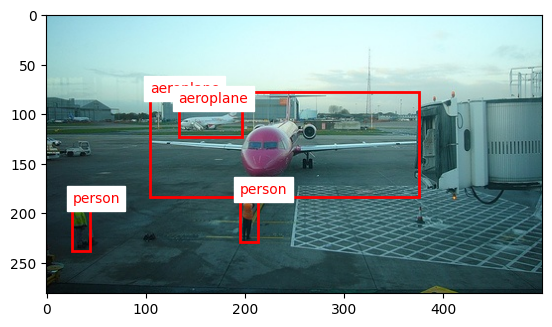

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def visualize_bounding_boxes(image_path, bounding_boxes):
    # Load the image
    img = cv2.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    for box in bounding_boxes:
        class_id, x, y, w, h = box
        # Create a rectangle patch
        class_name = Object_All[int(class_id)]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the axis
        ax.add_patch(rect)

        # Add class label (if available) next to the bounding box
        ax.text(x, y, f'{class_name}', color='r', backgroundcolor='white')

    # Show the image with bounding boxes
    plt.show()

# Example usage:
image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'
bounding_boxes = bbox_data
visualize_bounding_boxes(image_path, bounding_boxes)

<font size=5>1.2 Classifier for ”the presence of object” (bonus)<br><font size=3>1.2.1 Multi-hot encoding (bonus 5pts)

In [179]:
import numpy as np
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.models import vgg16_bn



class VOCDataset(Dataset):
    def __init__(self, path_folder, inshape=(96, 96)):
        self.path_folder = path_folder
        self.path_image = os.path.join(path_folder, 'JPEGImages')
        self.path_annotation = os.path.join(path_folder, 'Annotations')
        self.name_list = [x.split('.')[0] for x in os.listdir(self.path_image)]
        self.inshape = inshape

    def __len__(self):
        return len(self.name_list)

    def __getitem__(self, item):
        name = self.name_list[item]
        image = cv2.imread(os.path.join(self.path_image, '%s.jpg' % name))
        image = self.preprocess(image)
        label = extract_bounding_boxes(os.path.join(self.path_annotation, '%s.xml' % name))
        multi_hot = np.zeros(len(Object_All), dtype=int)
        for sub_label in label:
            multi_hot[sub_label[0]] = 1
        return image, multi_hot

    def preprocess(self, image):
        iw, ih = image.shape[0], image.shape[1]
        w, h = self.inshape
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2

        # resize and pad image
        image = cv2.resize(image, (nh, nw), cv2.INTER_CUBIC)
        new_image = np.zeros((*self.inshape, 3))
        new_image[dx:(dx+nw), dy:(dy+nh), :] = image

        new_image = (new_image - np.min(new_image)) / (np.max(new_image) - np.min(new_image))

        return new_image.transpose(2, 0, 1)


path = 'VOCdevkit/VOC2012'
dataset = VOCDataset(path_folder=path)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)
image, label = train_dataset[1]
print(label)
dataloader_train = DataLoader(train_dataset, batch_size=4, shuffle = True)
dataloader_validation = DataLoader(val_dataset, batch_size=4, shuffle = False)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<font size=3>1.2.2 Model for the classification of presence (bonus 10 pts)

In [ ]:
seed = 1
device = torch.device('cuda')
optimizer_name = 'Adam'
num_epochs = 5
lr = 1e-3
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, validation_loader, criterion, epoch)

<font size=5>1.3 RPN from scratch (40 pts)

In [93]:
import os
import cv2
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms
from torchvision.models import vgg16_bn

In [167]:
class VOCDataset_RPN(Dataset):
    def __init__(self, path_folder, inshape=(224, 224)):
        self.path_folder = path_folder
        self.path_image = os.path.join(path_folder, 'JPEGImages')
        self.path_annotation = os.path.join(path_folder, 'Annotations')
        self.name_list = [x.split('.')[0] for x in os.listdir(self.path_image)]
        self.inshape = inshape

    def __len__(self):
        return len(self.name_list)

    def __getitem__(self, item):
        name = self.name_list[item]
        image = cv2.imread(os.path.join(self.path_image, '%s.jpg' % name))
        label = extract_bounding_boxes(os.path.join(self.path_annotation, '%s.xml' % name))
        image, label = self.preprocess(image, label)
        return image, label

    def preprocess(self, image, label):
        iw, ih = image.shape[0], image.shape[1]
        w, h = self.inshape
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2

        # resize and pad image
        image = cv2.resize(image, (nh, nw), cv2.INTER_CUBIC)
        new_image = np.zeros((*self.inshape, 3))
        new_image[dx:(dx+nw), dy:(dy+nh), :] = image

        # deal with bounding box
        if label.shape[0] > 0:
            label[:, 1] = label[:, 1]*nw/iw + dy
            label[:, 2] = label[:, 2]*nh/ih + dx
            label[:, 3] = label[:, 3]*nw/iw
            label[:, 4] = label[:, 4]*nh/ih

        new_image = (new_image - np.min(new_image)) / (np.max(new_image) - np.min(new_image))

        return new_image.transpose(2, 0, 1), label

In [168]:
def visualize_proposed_box(image, label, bounding_boxes):

    fig, ax = plt.subplots(1)

    ax.imshow(image[..., [2, 1, 0]])

    for box in label:
        class_id, x, y, w, h = box
        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the axis
        ax.add_patch(rect)

    for box in bounding_boxes:
        class_id, x, y, w, h = box
        # Create a rectangle patch
        class_name = Object_All[int(class_id)]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')

        # Add the rectangle to the axis
        ax.add_patch(rect)

        # Add class label (if available) next to the bounding box
        ax.text(x, y, f'{class_name}', color='g', backgroundcolor='white')


    # Show the image with bounding boxes
    plt.show()

In [180]:
"""
Modified from https://github.com/bubbliiiing/faster-rcnn-pytorch
"""
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = - h / 2.
            anchor_base[index, 1] = - w / 2.
            anchor_base[index, 2] = h / 2.
            anchor_base[index, 3] = w / 2.
    return anchor_base


def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    shift_x             = np.arange(0, width * feat_stride, feat_stride)
    shift_y             = np.arange(0, height * feat_stride, feat_stride)
    shift_x, shift_y    = np.meshgrid(shift_x, shift_y)
    shift               = np.stack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel(),), axis=1)
    A       = anchor_base.shape[0]
    K       = shift.shape[0]
    anchor  = anchor_base.reshape((1, A, 4)) + shift.reshape((K, 1, 4))
    anchor  = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor

def loc2bbox(src_bbox, loc):
    if src_bbox.size()[0] == 0:
        return torch.zeros((0, 4), dtype=loc.dtype)

    src_width   = torch.unsqueeze(src_bbox[:, 2] - src_bbox[:, 0], -1)
    src_height  = torch.unsqueeze(src_bbox[:, 3] - src_bbox[:, 1], -1)
    src_ctr_x   = torch.unsqueeze(src_bbox[:, 0], -1) + 0.5 * src_width
    src_ctr_y   = torch.unsqueeze(src_bbox[:, 1], -1) + 0.5 * src_height

    dx          = loc[:, 0::4]
    dy          = loc[:, 1::4]
    dw          = loc[:, 2::4]
    dh          = loc[:, 3::4]

    ctr_x = dx * src_width + src_ctr_x
    ctr_y = dy * src_height + src_ctr_y
    w = torch.exp(dw) * src_width
    h = torch.exp(dh) * src_height

    dst_bbox = torch.zeros_like(loc)
    dst_bbox[:, 0::4] = ctr_x - 0.5 * w
    dst_bbox[:, 1::4] = ctr_y - 0.5 * h
    dst_bbox[:, 2::4] = ctr_x + 0.5 * w
    dst_bbox[:, 3::4] = ctr_y + 0.5 * h

    return dst_bbox

class ProposalCreator():
    def __init__(
        self,
        mode,
        nms_iou             = 0.7,
        n_train_pre_nms     = 12000,
        n_train_post_nms    = 600,
        n_test_pre_nms      = 3000,
        n_test_post_nms     = 300,
        min_size            = 16

    ):
        self.mode               = mode
        self.nms_iou            = nms_iou
        self.n_train_pre_nms    = n_train_pre_nms
        self.n_train_post_nms   = n_train_post_nms
        self.n_test_pre_nms     = n_test_pre_nms
        self.n_test_post_nms    = n_test_post_nms
        self.min_size           = min_size

    def __call__(self, loc, score, anchor, img_size, scale=1.):
        if self.mode == "training":
            n_pre_nms   = self.n_train_pre_nms
            n_post_nms  = self.n_train_post_nms
        else:
            n_pre_nms   = self.n_test_pre_nms
            n_post_nms  = self.n_test_post_nms

        anchor = torch.from_numpy(anchor).type_as(loc)

        roi = loc2bbox(anchor, loc)
        roi[:, [0, 2]] = torch.clamp(roi[:, [0, 2]], min = 0, max = img_size[1])
        roi[:, [1, 3]] = torch.clamp(roi[:, [1, 3]], min = 0, max = img_size[0])

        min_size    = self.min_size * scale
        keep        = torch.where(((roi[:, 2] - roi[:, 0]) >= min_size) & ((roi[:, 3] - roi[:, 1]) >= min_size))[0]
        roi         = roi[keep, :]
        score       = score[keep]

        order       = torch.argsort(score, descending=True)

        if n_pre_nms > 0:
            order   = order[:n_pre_nms]
        roi     = roi[order, :]
        score   = score[order]

        keep    = nms(roi, score, self.nms_iou)
        if len(keep) < n_post_nms:
            index_extra = np.random.choice(range(len(keep)), size=(n_post_nms - len(keep)), replace=True)
            keep        = torch.cat([keep, keep[index_extra]])
        keep    = keep[:n_post_nms]
        roi     = roi[keep]
        return roi

In [181]:
"""
Modified from https://github.com/bubbliiiing/faster-rcnn-pytorch
"""
class RegionProposalNetwork(nn.Module):
    def __init__(
        self,
        in_channels     = 512,
        mid_channels    = 512,
        ratios          = [0.5, 1, 2],
        anchor_scales   = [8, 16, 32],
        feat_stride     = 16,
        mode            = "training",
    ):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base    = generate_anchor_base(anchor_scales = anchor_scales, ratios = ratios)
        n_anchor            = self.anchor_base.shape[0]
        self.conv1  = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score  = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc    = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.feat_stride    = feat_stride
        self.proposal_layer = ProposalCreator(mode)

    def forward(self, x, img_size, scale=1.):
        n, _, h, w = x.shape
        x = F.relu(self.conv1(x))
        rpn_locs = self.loc(x)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(x)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous().view(n, -1, 2)
        rpn_softmax_scores = F.softmax(rpn_scores, dim=-1)
        rpn_fg_scores = rpn_softmax_scores[:, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, h, w)
        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], anchor, img_size, scale = scale)
            batch_index = i * torch.ones((len(roi),))
            rois.append(roi.unsqueeze(0))
            roi_indices.append(batch_index.unsqueeze(0))

        rois = torch.cat(rois, dim=0).type_as(x)
        roi_indices = torch.cat(roi_indices, dim=0).type_as(x)
        anchor = torch.from_numpy(anchor).unsqueeze(0).float().to(x.device)

        return rpn_locs, rpn_scores, rois, roi_indices, anchor

In [171]:
extractor = vgg16_bn(pretrained=True).features
rpn = RegionProposalNetwork(
    512, 512,
    ratios = [0.5, 1, 2],
    anchor_scales = [8, 16, 32],
    feat_stride = 16,
    mode = 'training'
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


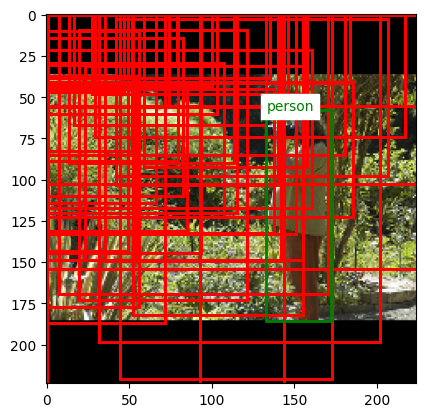

In [178]:
train_set = VOCDataset_RPN(path_folder='VOCdevkit/VOC2012')
image, label = train_set[80]
base_feature = extractor(torch.tensor(image, dtype=torch.float32).unsqueeze(0))
_, _, rois, roi_indices, _  = rpn.forward(base_feature, (224, 224))
rois_ours = rois.clone().squeeze()
rois_ours[:, 2] = rois_ours[:, 2] - rois_ours[:, 0]
rois_ours[:, 3] = rois_ours[:, 3] - rois_ours[:, 1]
rois_ours = torch.cat([torch.zeros((rois_ours.shape[0], 1)), rois_ours], dim=1)
visualize_proposed_box(image.transpose(1, 2, 0), rois_ours.detach().numpy(), label)

<font size=6>2 Problem 2: Denoising AutoEncoders (35pts)

In [10]:
import numpy as np
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [182]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class VOCDataset_AutoEncoder(Dataset):
    def __init__(self, path_folder, transform):
        self.path_folder = path_folder
        self.path_image = os.path.join(path_folder, 'JPEGImages')
        self.path_annotation = os.path.join(path_folder, 'Annotations')
        self.name_list = [x.split('.')[0] for x in os.listdir(self.path_image)]
        self.transform = transform


    def __len__(self):
        return len(self.name_list)

    def __getitem__(self, item):
        name = self.name_list[item]
        image = cv2.imread(os.path.join(self.path_image, '%s.jpg' % name))
        image = (image - np.min(image))/(np.max(image)-np.min(image))
        image = torch.tensor(image.transpose(2,0,1))
        image = image[:,0:64,0:64].float()
        corrupted_image = self.transform(image)

        return corrupted_image, image

In [12]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.Encoder(x)
        out = self.Decoder(out)
        return out

In [13]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * output.shape[0] # sum up batch loss

    test_loss = test_loss/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))

In [14]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

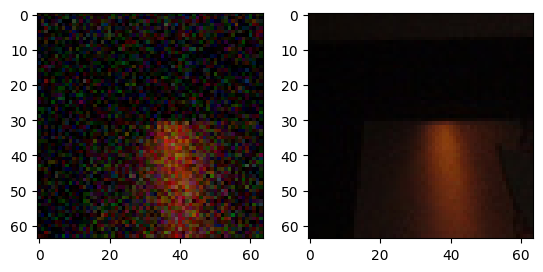

In [16]:
mytransform=transforms.Compose([
    AddGaussianNoise(0., .1)
])


path = 'VOCdevkit/VOC2012'
dataset = VOCDataset_AutoEncoder(path_folder=path, transform=mytransform)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)
corrupted_image, image = train_dataset[1]
image = image.numpy().transpose(1,2,0)
image = image[..., [2, 1, 0]]
corrupted_image = corrupted_image.numpy().transpose(1,2,0)
corrupted_image = corrupted_image[..., [2, 1, 0]]

# Create a figure and axis
plt.figure()
plt.subplot(1,2,1)
plt.imshow(corrupted_image)
plt.subplot(1,2,2)
plt.imshow(image)
plt.show()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size=16, shuffle = False)

In [18]:
seed = 1
device = torch.device('cuda')
optimizer_name = 'Adam'
num_epochs = 5
lr = 1e-3
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, validation_loader, criterion, epoch)

Train(1)[0%]: Loss: 0.1145
Train(1)[50%]: Loss: 0.0140
Train(1)[100%]: Loss: 0.0113
Test(1): Loss: 0.0091
Train(2)[0%]: Loss: 0.0076
Train(2)[50%]: Loss: 0.0073
Train(2)[100%]: Loss: 0.0070
Test(2): Loss: 0.0049
Train(3)[0%]: Loss: 0.0073
Train(3)[50%]: Loss: 0.0060
Train(3)[100%]: Loss: 0.0059
Test(3): Loss: 0.0041
Train(4)[0%]: Loss: 0.0031
Train(4)[50%]: Loss: 0.0059
Train(4)[100%]: Loss: 0.0054
Test(4): Loss: 0.0042
Train(5)[0%]: Loss: 0.0039
Train(5)[50%]: Loss: 0.0048
Train(5)[100%]: Loss: 0.0048
Test(5): Loss: 0.0042


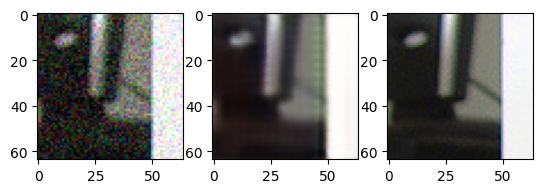

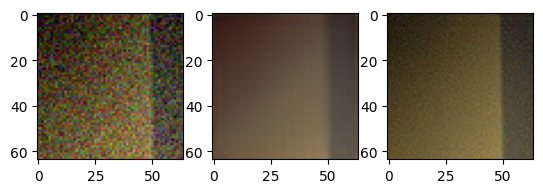

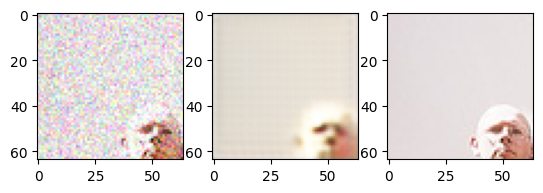

In [25]:
model.eval()
show_list = [2, 3, 7]
for idx in show_list:
  corrupted_image, original_image = train_dataset[idx]
  restored_image = model(original_image.unsqueeze(0).to(device)).cpu()
  original_image = original_image.numpy().transpose(1,2,0)
  original_image = original_image[..., [2, 1, 0]]
  corrupted_image = corrupted_image.numpy().transpose(1,2,0)
  corrupted_image = corrupted_image[..., [2, 1, 0]]
  restored_image = restored_image.detach().squeeze(0).numpy().transpose(1,2,0)
  restored_image = restored_image[..., [2, 1, 0]]

  # Create a figure and axis
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(corrupted_image)
  plt.subplot(1,3,2)
  plt.imshow(restored_image)
  plt.subplot(1,3,3)
  plt.imshow(original_image)
  plt.show()